# Predicting the energy price

The dataset contains two distinct .csv files which contain information about the energy and weather patterns in spain for 2015-2019: 
> **`'weather_features.csv':`** Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of 5 major cities of Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).

> **`'energy_dataset.csv':`** Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about every type of energy which is used to generate energy (fossil gas, fossil hard coal and wind energy dominate the energy grid), as well as about the total load (energy demand) of the national grid and the price of energy (&euro;/MWh). 
_Note: Since the generation of each energy type is in MW and the time-series contains hourly info, the number of each cell represent MWh._

**The dataset can be found [HERE!](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)**

The information that we have about the weather of 5 major cities in Spain (highlighted by a red star on the map below) is probably more than enough for our analysis, since their geographic distribution covers most of the part of Spain's territory in a uniform manner. Moreover, it is useful to note that these 5 cities alone comprise approximately 1/3rd of the total population of Spain.

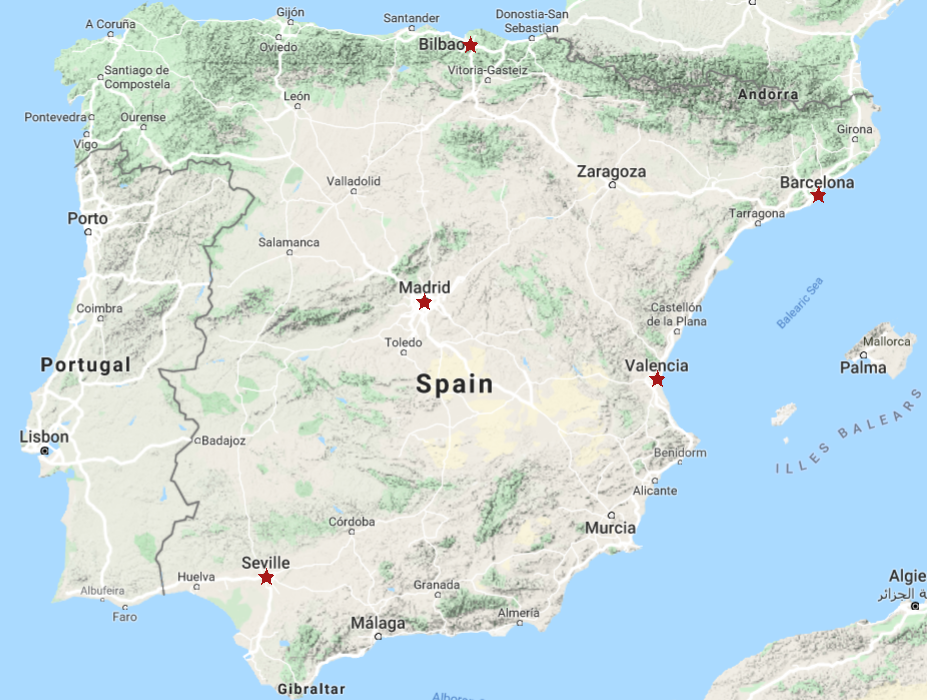

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from difflib import SequenceMatcher
from math import sqrt, ceil
%matplotlib inline

## 1. Exploration and cleaning

In [2]:
df_weather = pd.read_csv('weather_features.csv', parse_dates=['dt_iso'])
df_energy = pd.read_csv('energy_dataset.csv', parse_dates=['time'])

### 1.1. Energy Dataset

First, we will work on `energy_dataset.csv`, which we will hereby refer to as `df_energy`.

In [3]:
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [4]:
df_energy.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0               35046.00   
mean                                  0.0                5622.74   
std                                   0.0                2201.83   
min                                   0.0                   0.00   
25%                                   0.0                4126.00   
50%                                   0.0                4969.00   
75%                                   0.0                6429.00   
max                                   0.0               20034.00   

       generation fossil hard coal  generation fossil oil  \
count                     35046.00               35045.00   
mean                       4256.07                 298.32   
std                        1961.60                  52.52   
min                           0.00                   0.00   
25%                        2527.00                 263.00   
50%                        4474.00                 300.00   
75%                        5838.75                 330.00   
max                        8359.00                 449.00   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       generation waste  generation wind offshore  generation wind onshore  \
count          35045.00                   35046.0                 35046.00   
mean             269.45                       0.0                  5464.48   
std               50.20                       0.0                  3213.69   
min                0.00                       0.0                     0.00   
25%              240.00                       0.0                  2933.00   
50%              279.00                       0.0                  4849.00   
75%              310.00                       0.0                  7398.00   
max              357.00                       0.0                 17436.00   

       forecast solar day ahead  forecast wind offshore eday ahead  \
count                  35064.00                                0.0   
mean                    1439.07                                NaN   
std                     1677.70       

We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable.

In [5]:
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead'], 
                            axis=1)

In [6]:
df_energy.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil gas  generation fossil hard coal  \
count               35046.00                     35046.00   
mean                 5622.74                      4256.07   
std                  2201.83                      1961.60   
min                     0.00                         0.00   
25%                  4126.00                      2527.00   
50%                  4969.00                      4474.00   
75%                  6429.00                      5838.75   
max                 20034.00                      8359.00   

       generation fossil oil  generation hydro pumped storage consumption  \
count               35045.00                                     35045.00   
mean                  298.32                                       475.58   
std                    52.52                                       792.41   
min                     0.00                                         0.00   
25%                   263.00                                         0.00   
50%                   300.00                                        68.00   
75%                   330.00                                       616.00   
max                   449.00                                      4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water reservoir  generation nuclear  generation other  \
count                          35046.00            35047.00          35046.00   
mean                            2605.11             6263.91             60.23   
std                             1835.20              839.67             20.24   
min                                0.00                0.00              0.00   
25%                             1077.25             5760.00             53.00   
50%                             2164.00             6566.00             57.00   
75%                             3757.00             7025.00             80.00   
max                             9728.00             7117.00            106.00   

       generation other renewable  generation solar  generation waste  \
count                    35046.00          35046.00          35045.00   
mean                        85.64           1432.67            269.45   
std                         14.08           1680.12             50.20   
min                          0.00              0.00              0.00   
25%                         73.00             71.00            240.00   
50%                         88.00            616.00            279.00   
75%                         97.00           2578.00            310.00   
max                        119.00           5792.00            357.00   

       generation wind onshore  forecast solar day ahead  \
count                 35046.00                  35064.00   
mean                   5464.48                   1439.07   
std                    3213.69                   1677.70   
min                       0.00                      0

We can already see that the columns of `df_energy` have different numbers (count) of rows and thus, we expect some null data. Apart from that, we can see that the forecasted price ('price day ahead') is generally lower than the actual price ('price actual'). That means that the model used by the TSO tends to underestimate the energy price. 

In [7]:
# Print the type of each variable in the dataset

df_energy.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
forecast solar day ahead                       float64
forecast wind onshore day ahead                float64
total load forecast                            float64
total load

The 'time' column, which also functions as the index for the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [8]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [9]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non-null float64
generation hydro water reservoir               35046 non-null float64
generation nuclear                             35047 non-null float64
generation other                               35046 non-null float64
generation other renewable                     35046 non-null float64
generation solar                               35046 non-null float64
gene

In [10]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'.format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy (except first occurrence) based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy (except first occurrence) based on all columns.


As we can see, `df_energy` has no duplicate values. Nevertheless, it has some NaNs and thus, we have to investigate further. Since this is a time-series forecasting task, we cannot simply drop the rows with the missing values and it would be a better idea to fill the missing values using interpolation.

In [11]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


Most null values can be found in the 'total load actual' column. Therefore, it is a good idea to visualize it and see what we can do. The good news is that there are no NaNs neither in the 'price day ahead' nor in the 'price actual' columns, which we will use as the target variable in order to train our model. The similar numbers in null values in the columns which have to do with the type of energy generation probably indicate that they will also appear in the same rows. Let us first define a plot function which we will then use so as to visualize the 'total load actual' column, as well as other columns.

In [12]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe and which
    constitutes one of its columns or it a custom pandas series created by the user.
    The user can define either the 'df' and the 'column' or the 'series' and additionally,
    can also define the 'label', the 'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/home/dimitriosrou/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


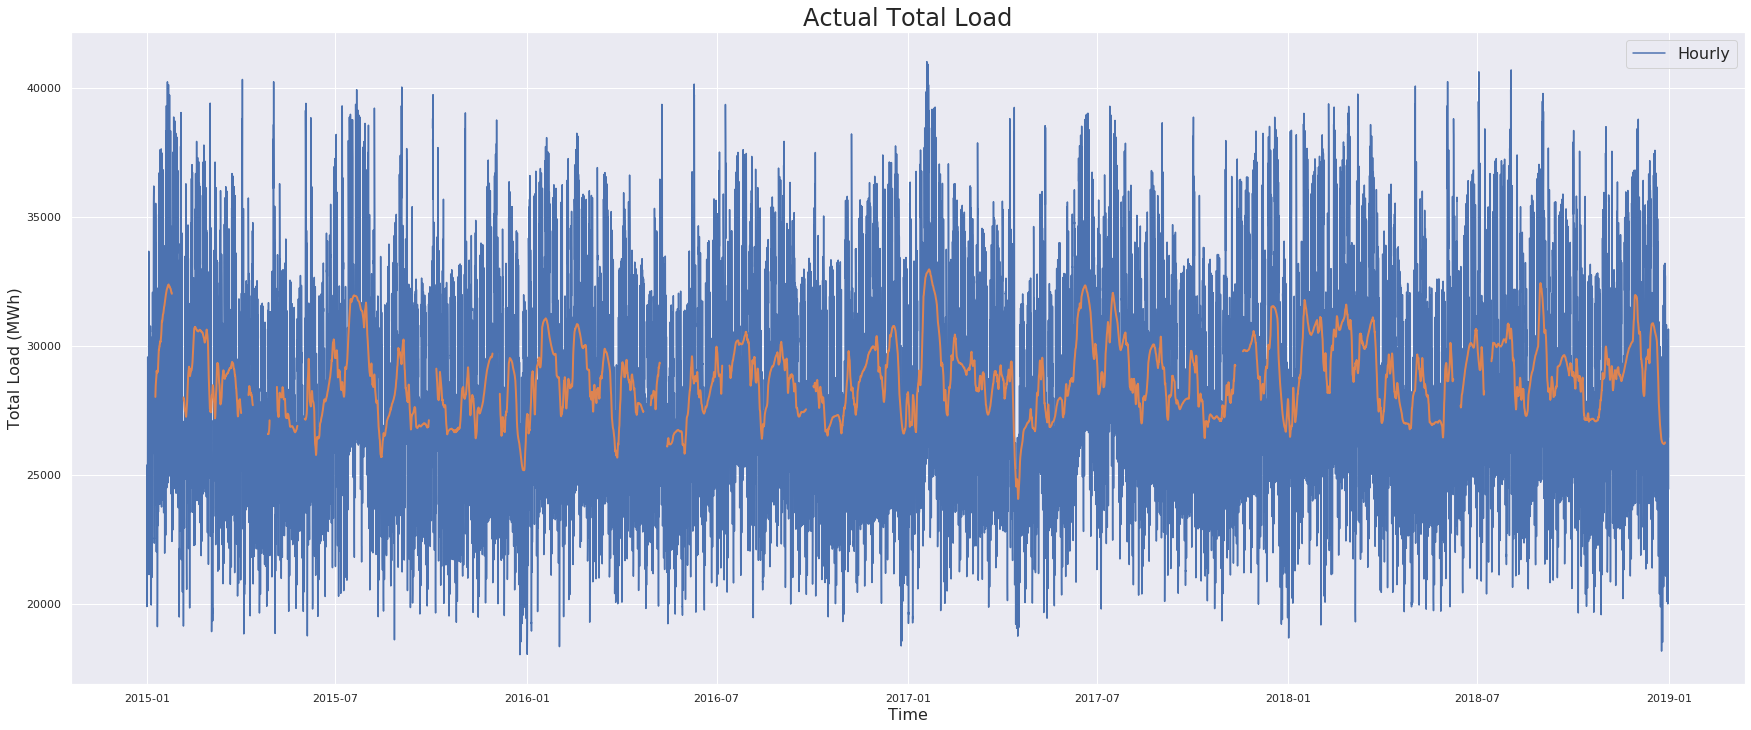

In [13]:
# Plot the hourly (actual) total load, along with the weekly rolling mean

rolling = df_energy['total load actual'].rolling(24*7, center=True).mean()
ax = plot_series(df=df_energy, column='total load actual', label='Hourly', 
                 ylabel='Total Load (MWh)', title='Actual Total Load')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

At this scale, the actual total load behaves like white noise. However, the perceptive reader will notice that some discontinuities in the weekly rolling mean can already be observed. 

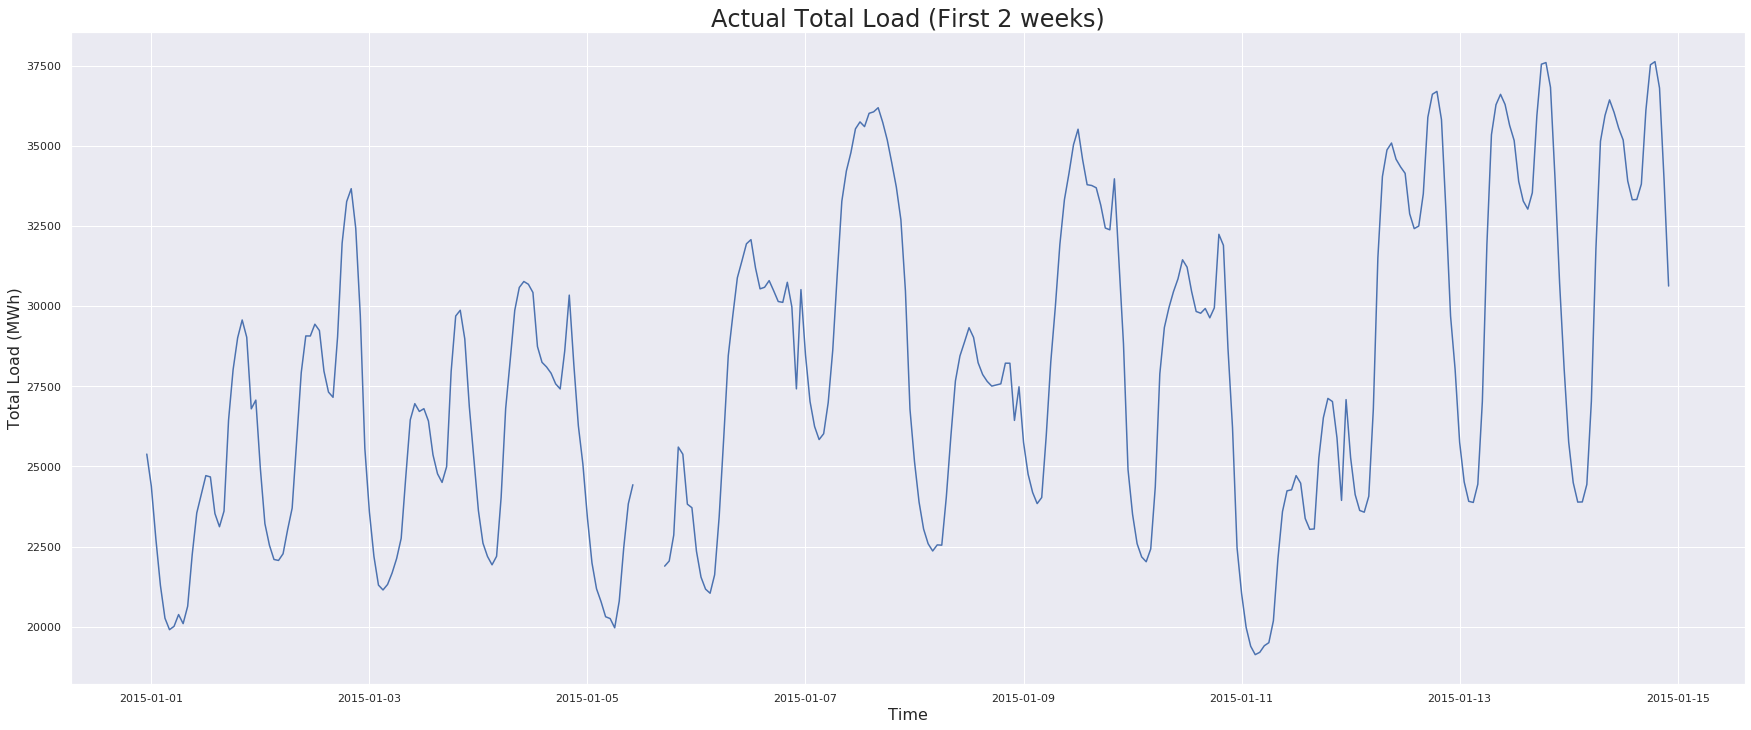

In [14]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks)', end=24*7*2)
plt.show()

After zooming into the first 2 weeks of the 'total load actual' column, we can already see that there are null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Since they are not so many, we can display all of them.

In [15]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)]

generation biomass  \
time                                            
2015-01-05 02:00:00+00:00                 NaN   
2015-01-05 11:00:00+00:00                 NaN   
2015-01-05 12:00:00+00:00                 NaN   
2015-01-05 13:00:00+00:00                 NaN   
2015-01-05 14:00:00+00:00                 NaN   
2015-01-05 15:00:00+00:00                 NaN   
2015-01-05 16:00:00+00:00                 NaN   
2015-01-19 18:00:00+00:00                 NaN   
2015-01-19 19:00:00+00:00                 NaN   
2015-01-27 18:00:00+00:00                 NaN   
2015-01-28 12:00:00+00:00                 NaN   
2015-02-01 06:00:00+00:00               449.0   
2015-02-01 07:00:00+00:00               453.0   
2015-02-01 08:00:00+00:00               452.0   
2015-02-01 11:00:00+00:00               405.0   
2015-02-01 12:00:00+00:00               402.0   
2015-02-01 13:00:00+00:00               400.0   
2015-02-01 14:00:00+00:00               393.0   
2015-02-01 15:00:00+00:00               413.0   
2015-02-01 16:00:00+00:00               465.0   
2015-02-01 17:00:00+00:00               482.0   
2015-02-01 18:00:00+00:00               474.0   
2015-04-05 01:00:00+00:00               371.0   
2015-04-16 07:00:00+00:00                 NaN   
2015-04-20 06:00:00+00:00               424.0   
2015-04-23 19:00:00+00:00                 NaN   
2015-05-02 08:00:00+00:00               497.0   
2015-05-29 01:00:00+00:00               569.0   
2015-06-15 07:00:00+00:00                 NaN   
2015-10-02 06:00:00+00:00               483.0   
2015-10-02 09:00:00+00:00                 NaN   
2015-12-02 08:00:00+00:00                 NaN   
2016-04-13 03:00:00+00:00               220.0   
2016-04-25 03:00:00+00:00               190.0   
2016-04-25 05:00:00+00:00               206.0   
2016-05-10 21:00:00+00:00               348.0   
2016-06-11 23:00:00+00:00               356.0   
2016-07-09 20:00:00+00:00                 NaN   
2016-07-11 22:00:00+00:00               346.0   
2016-09-28 07:00:00+00:00               347.0   
2016-10-27 21:00:00+00:00               351.0   
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 02:00:00+00:00                                   NaN   
2015-01-05 11:00:00+00:00                                   NaN   
2015-01-05 12:00:00+00:00                                   NaN   
2015-01-05 13:00:00+00:00                                   NaN   
2015-01-05 14:00:00+00:00                                   NaN   
2015-01-05 15:00:00+00:00                                   NaN   
2015-01-05 16:00:00+00:00                                   NaN   
2015-01-19 18:00:00+00:00                                   NaN   
2015-01-19 19:00:00+00:00                                   NaN   
2015-01-27 18:00:00+00:00                                   NaN   
2015-01-28 12:00:00+00:00                                   NaN   
2015-02-01 06:00:00+00:00                                 312.0   
2015-02-01 07:00:00+00:00                                 312.0   
2015-02-01 08:00:00+00:00                                 302.0   
2015-02-01 11:00:00+00:00                                 317.0   
2015-02-01 12:00:00+00:00                                 317.0   
2015-02-01 13:00:00+00:00                                 317.0   
2015-02-01 14:00:00+00:00                                 321.0   
2015-02-01 15:00:00+00:00                                 325.0   
2015-02-01 16:00:00+00:00                                 321.0   
2015-02-01 17:00:00+00:00                                 326.0   
2015-02-01 18:00:00+00:00                                 326.0   
2015-04-05 01:00:00+00:00                                   0.0   

We can confirm that the null values in the columns which have to do with the type of energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well.

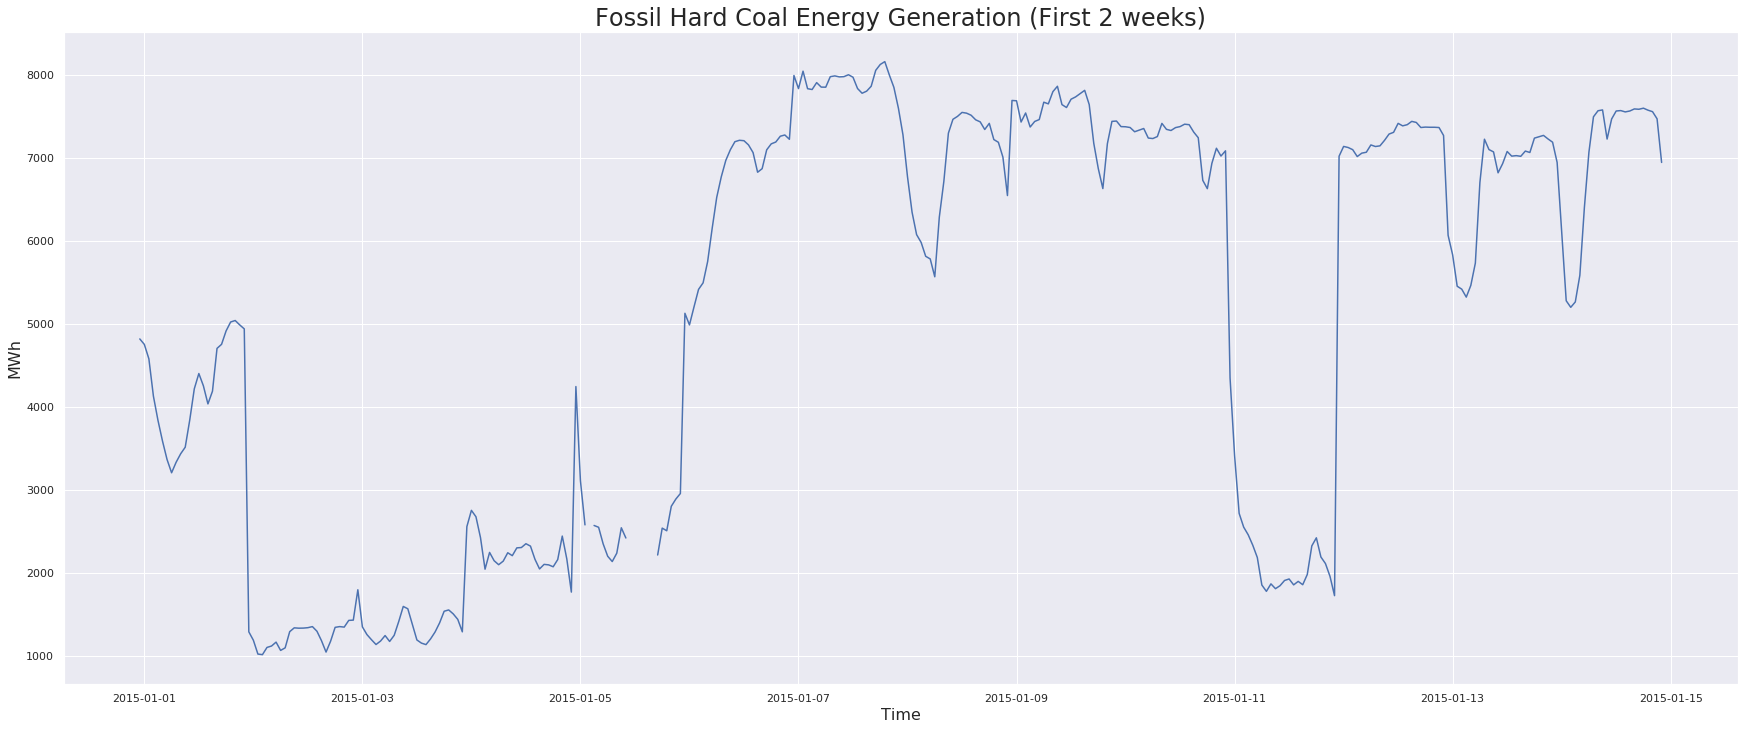

In [16]:
# Zoom into the null values of 'generation fossil hard coal'

ax = plot_series(df=df_energy, column='generation fossil hard coal', ylabel='MWh',
                 title='Fossil Hard Coal Energy Generation (First 2 weeks)', end=24*7*2)
plt.show()

In order to handle the null values in `df_energy`, we will use a linear interpolation with a forward direction. Perhaps other kinds of interpolation would be better; nevertheless, we prefer to use the simplest model possible. Only a small part of our input data will be noisy and it will not affect performance noticeably.

In [17]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

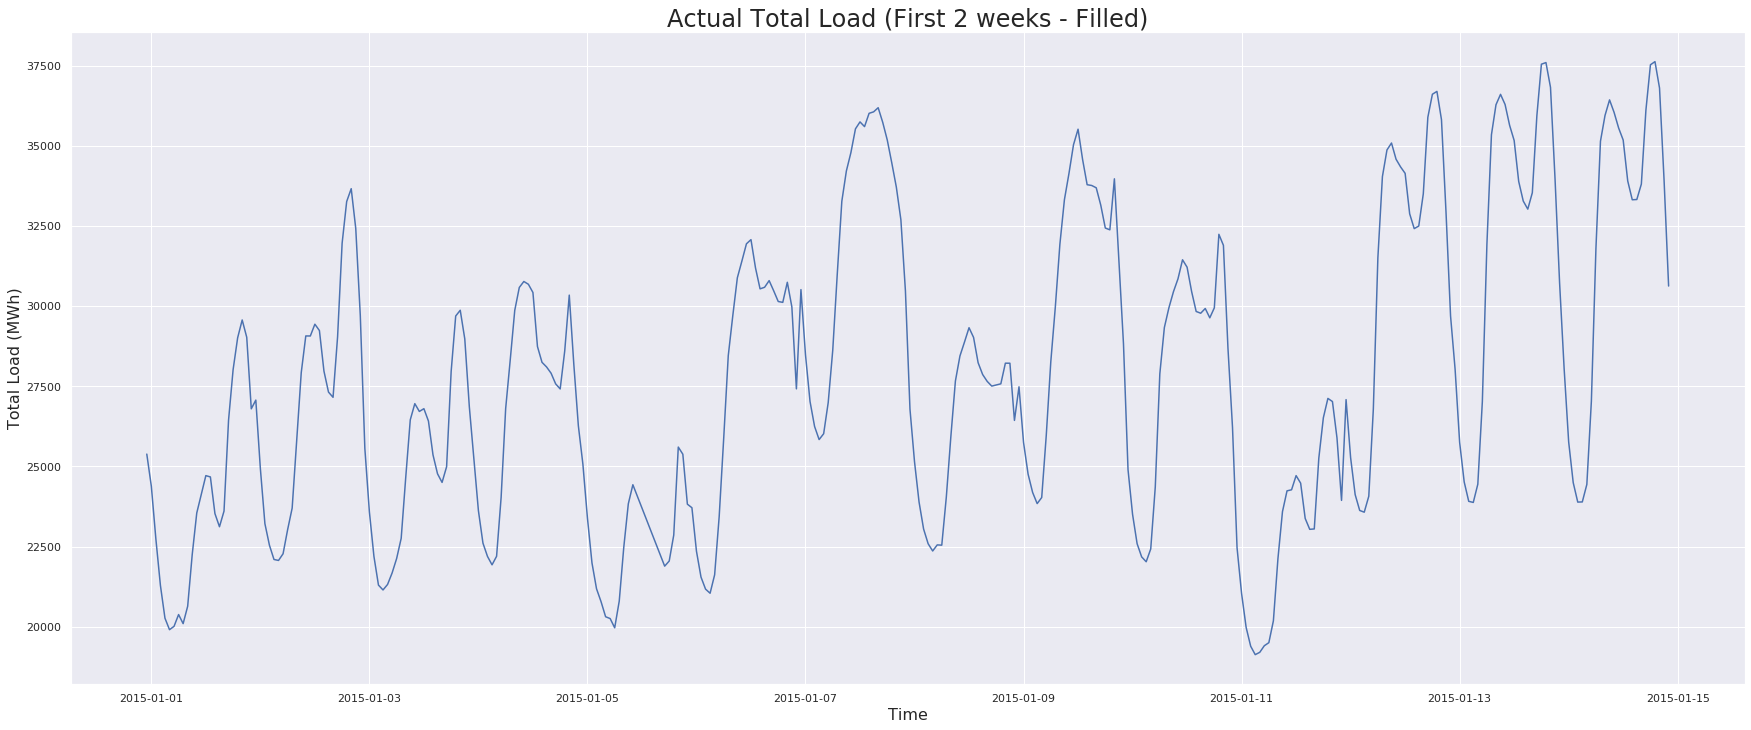

In [18]:
# Zoom again into the plot of the filled hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Filled)', end=24*7*2)
plt.show()

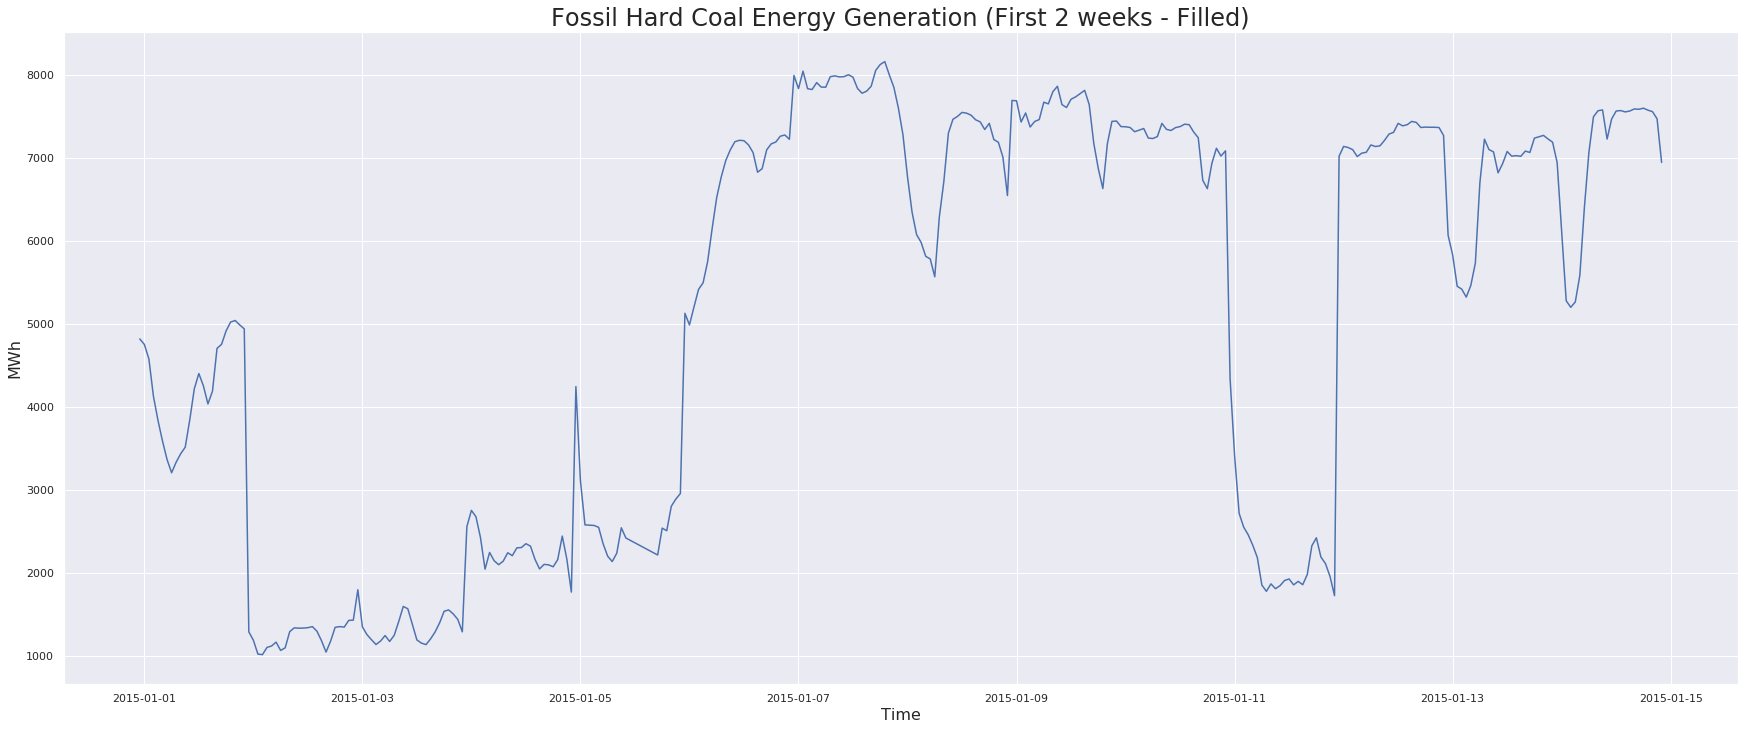

In [19]:
# Zoom again into the plot of the filled hourly 'generation fossil hard coal'

ax = plot_series(df=df_energy, column='generation fossil hard coal', ylabel='MWh',
                 title='Fossil Hard Coal Energy Generation (First 2 weeks - Filled)', end=24*7*2)
plt.show()

In [20]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
forecast solar day ahead                       34525
forecast wind onshore day ahead                35064
total load forecast                            35064
total load actual                              35064
price day ahe

It look like `df_energy` has been cleaned successfully and is ready for further use as input into our model. The 1-4 zeroes in the columns which have to do with energy generation by type should not concern us very much. The 'generation hydro pumped storage consumption' may look suspicious, but we should have in mind that this type of energy is only used for load balancing, being consumed when in peak energy demands. The column which would need some deeper examination is 'forecast solar day ahead'. However, we will most likely not need it at all in the training process of our model (as well as 'forecast wind onshore day ahead').

### 1.2. Weather features dataset

Now, we move on to work with `weather_features.csv`, which we will refer to as `df_weather` from now on.

In [21]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [22]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

Here, we can see that all columns of `df_weather` have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. Below, we can see the formulas to convert the temperature into Celsius and Fahrenheit, just in case we want to get a better sense of the temperature values in the dataset. 

$$T_{Celsius} = {T_{Kelvin} + {273.15}}$$ 

$$T_{Fahrenheit} = {T_{Kelvin} * {9 \over 5} - {459.67}}$$ 

But, the most important thing to notice is that there are some **problems** and **outliers**. In particular:
- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface [[1]](#ref1). This cannot be the case here.
- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado [[2]](#ref2), a F5 (the largest intensity of the Fujita scale) tornado. A tornado of such intensity has not been recorded in Spain [[3]](#ref3) and hopefully will not happen in the future as well. 
- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'. However, this is not the case in the statistical description above. So, it would be a good idea to further examine those columns.

In [23]:
# Print the type of each variable in df_weather

df_weather.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

We have to change the type of some of the columns, so that all of them are float64. We also have to parse 'dt_iso' correctly and actually rename it as 'time' so that it matches with the index of `df_energy`.

In [24]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [25]:
# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [26]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [27]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
city_name              178396 non-null object
temp                   178396 non-null float64
temp_min               178396 non-null float64
temp_max               178396 non-null float64
pressure               178396 non-null float64
humidity               178396 non-null float64
wind_speed             178396 non-null float64
wind_deg               178396 non-null float64
rain_1h                178396 non-null float64
rain_3h                178396 non-null float64
snow_3h                178396 non-null float64
clouds_all             178396 non-null float64
weather_id             178396 non-null float64
weather_main           178396 non-null object
weather_description    178396 non-null object
weather_icon           178396 non-null object
dtypes: float64(12), object(4)
memory usage: 23.1+ MB


We have to split the `df_weather` dataset into 5 datasets, one for each different city (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).

In [28]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [29]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'.format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather except first occurrence based on all columns.'.format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather except first occurrence based on all columns.


It seems that `df_weather` has some *duplicate values*. However, **the method above may also show us rows which have the exame same values**. This is not what we are looking for. What we want to ensure, is that **there are no duplicate index rows**, i.e. that we do not have multiple rows **for the exact same hour**. Of course, we also have to make sure that these duplicates concern **each individual city**. Since, `df_weather` contains information about 5 different cities, it is very useful to display the number of observations for each one and compare it with the size of `df_energy`.

In [30]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'.format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


As we can see, the two dataframes (`df_energy` and `df_weather`) cannot be merged yet. There are many duplicates for every city in `df_weather` and we should drop them and see if their number of rows match. We do this by resetting the index, keeping only the **first rows** which have the same 'time' and 'city_name' values and then setting again 'time' as the index. For further research on the dataset, let us also create a second dataframe, `df_weather_2` in which we do the same procedure, but keep only the **last rows** which have the same 'time' and 'city_name'.

In [31]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [32]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'.format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


The column 'weather_icon' is irrelevant for our analysis, so we will drop it. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; the information concerns a qualitative description of the weather at the given hour. So, we will work with only one of them. However, in order to make a choice, we have to check the **unique values** as well as the **consistency** of each column. 

In [33]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [34]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [35]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, `df_weather` and `df_weather_2`. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.

In [36]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [37]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in `df_weather`. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that **the R² values of these two are not comparable** because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the Levenshtein distance, i.e. the number of edits required to transform string A to string B.

In [38]:
df_weather = df_weather.drop(['weather_main', 'weather_id', 'weather_icon'], axis=1)

We have to emphasize that the method we employed above in order to check the consistency of our dataset **is not 100% accurate**. This is because it compares two dataframes from which we have cleaned the duplicates in **only two ways exclusively**; keeping the first rows and keeping the last rows of the duplicates. Nevertheless, it gives good results and can be used to check the values of the other columns as well. We should not that since we removed the duplicates based on all the columns except 'time' and 'city_name', there is no point in checking the latter.

In [39]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0
R-Squared score of weather_description is 0.973


The above confirms our intuition that 'weather_description', 'weather_main' and 'weather_id' are the sole culprits for the duplicates in `df_weather` and although we are not absolutely certain for this (for the reasons we described above), it is more than enough to reaffirm the validity and consistency of the rest of the columns in `df_weather` which contain numerical values.

In [40]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], keep='first').sum()
print('There are {} duplicate rows in df_weather except first occurrence ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather except first occurrence based on all columns except "time" and "city_name".


Everything looks nice and clean and `df_weather` is also ready for use as input in our model

In this section we have performed an exploration on the datasets and have determined what is to be further examined and/or cleaned:
- Determine which weather description to keep in `df_energy`
- Investigate the columns in `df_weather` which contain outliers or anomalies

## 2. Visualizations and cleaning

/home/dimitriosrou/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/home/dimitriosrou/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


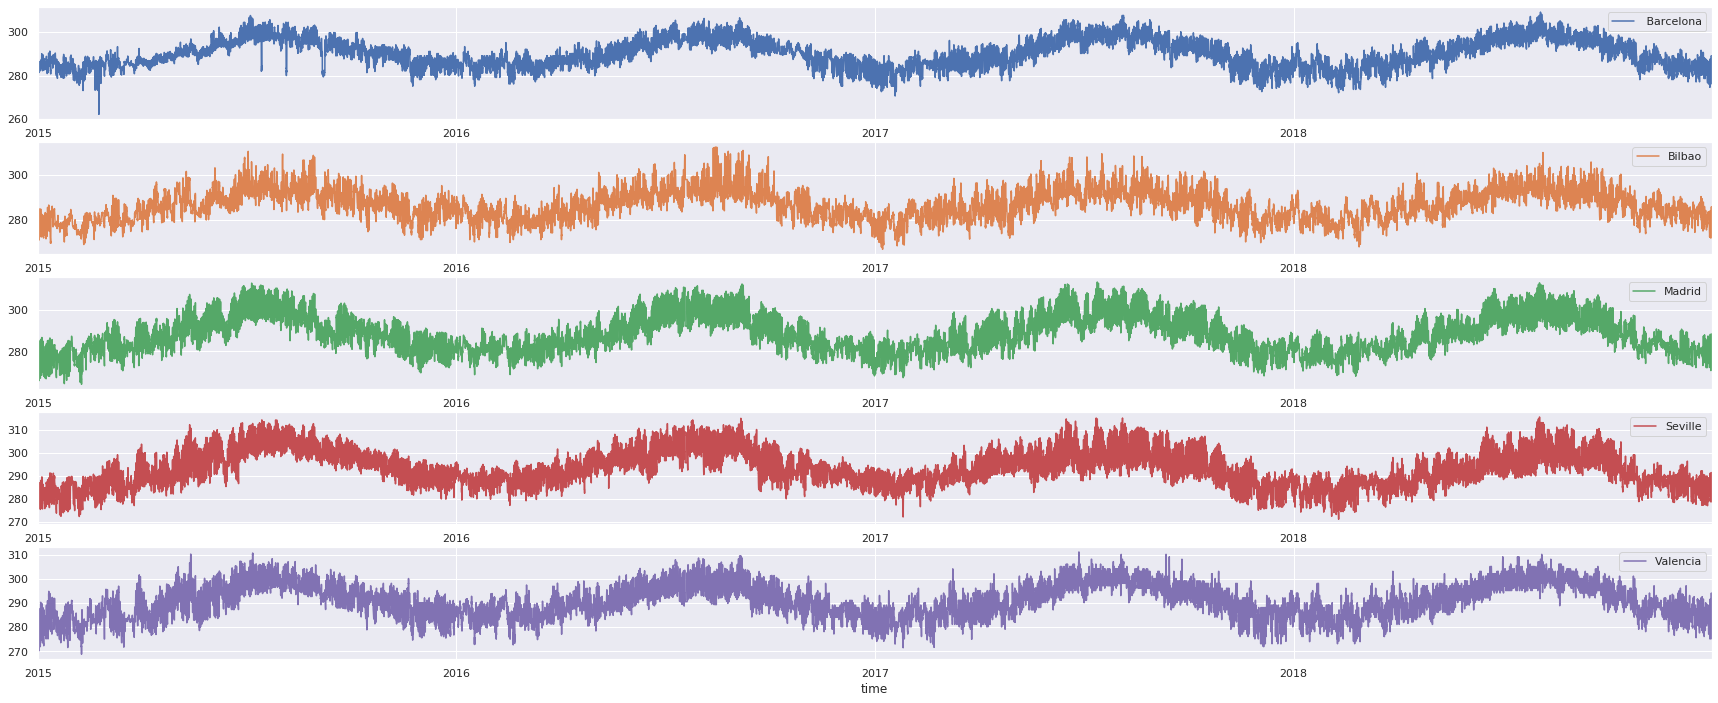

In [41]:
# Plot the hourly temperature for each city

sns.set()
fig, ax = plt.subplots(figsize=(30, 12))
temp_by_city = df_weather.pivot_table('temp', index='time', columns='city_name', aggfunc='mean')
temp_by_city.plot(ax=ax, subplots=True)
ax.set_title('Hourly temperature for each city')
plt.show()

Below, we are going to plot the monthly frequency of the temperature for all cities in a common figure. We expect to see a common seasonal pattern in all 5 cities, which peaks during summer months (July-August) and reaches the lowest during winter months (December-January).

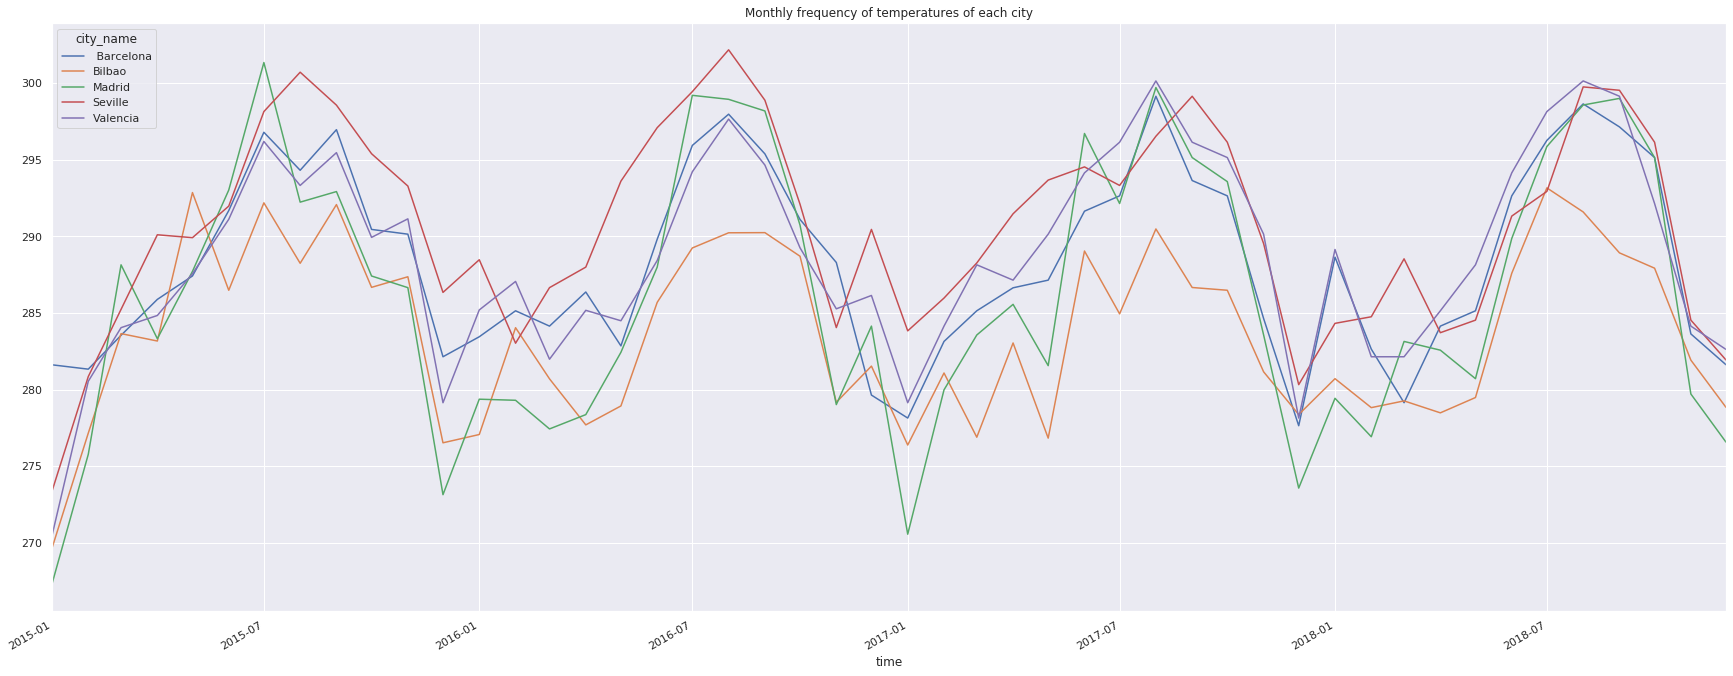

In [42]:
# Plot the temperature (monthly frequency) for all cities

sns.set()
fig, ax = plt.subplots(figsize=(30, 12))
temp_by_city.asfreq('M').plot(ax=ax, title='Monthly frequency of temperatures of each city')
plt.show()

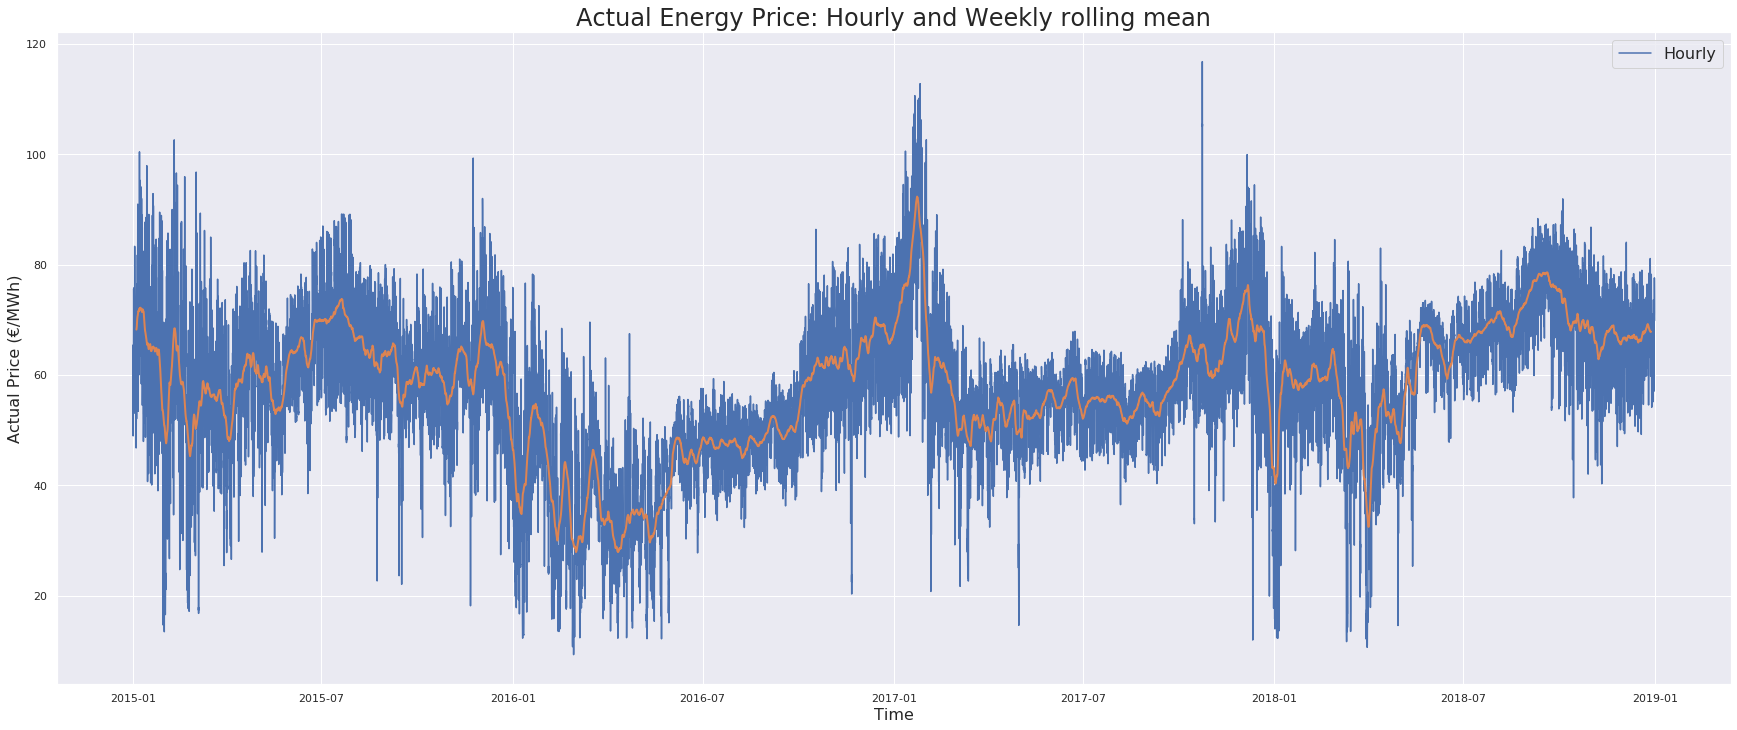

In [43]:
# Plot the hourly (actual) energy price, along with the weekly rolling mean

rolling = df_energy['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_energy, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Energy Price: Hourly and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

The greatest characteristic of this dataset is that it also contains the forecasts for total load and price made by the TSO (Transmission Service Operator) "Red Electrica de Espana". Before computing the accuracy of its forecasts, it would be a good idea to visualize errors between the actual and the forecasted quantities in a standardized manner, i.e. looking at how many standard deviations (of the actual quantities) they differ.

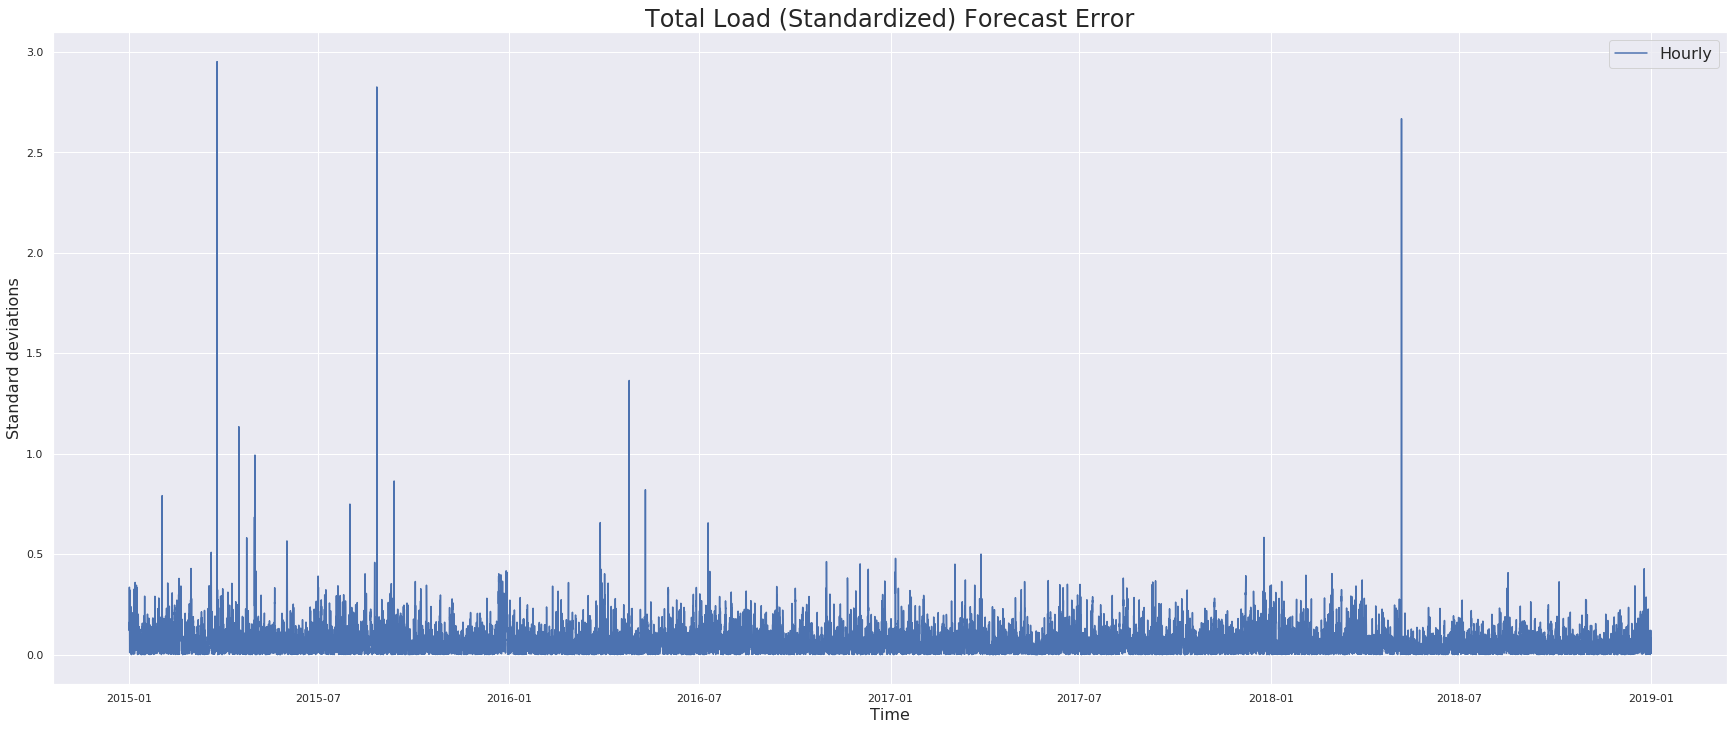

In [44]:
# Plot the standardized absolute hourly error between the actual total load and the forecasted total load

error_load = abs(df_energy['total load actual'] - df_energy['total load forecast'])
standardized_error_load = error_load / (df_energy['total load actual'].std())
ax = plot_series(series=standardized_error_load, label='Hourly', 
            ylabel='Standard deviations', title='Total Load (Standardized) Forecast Error')
plt.show()

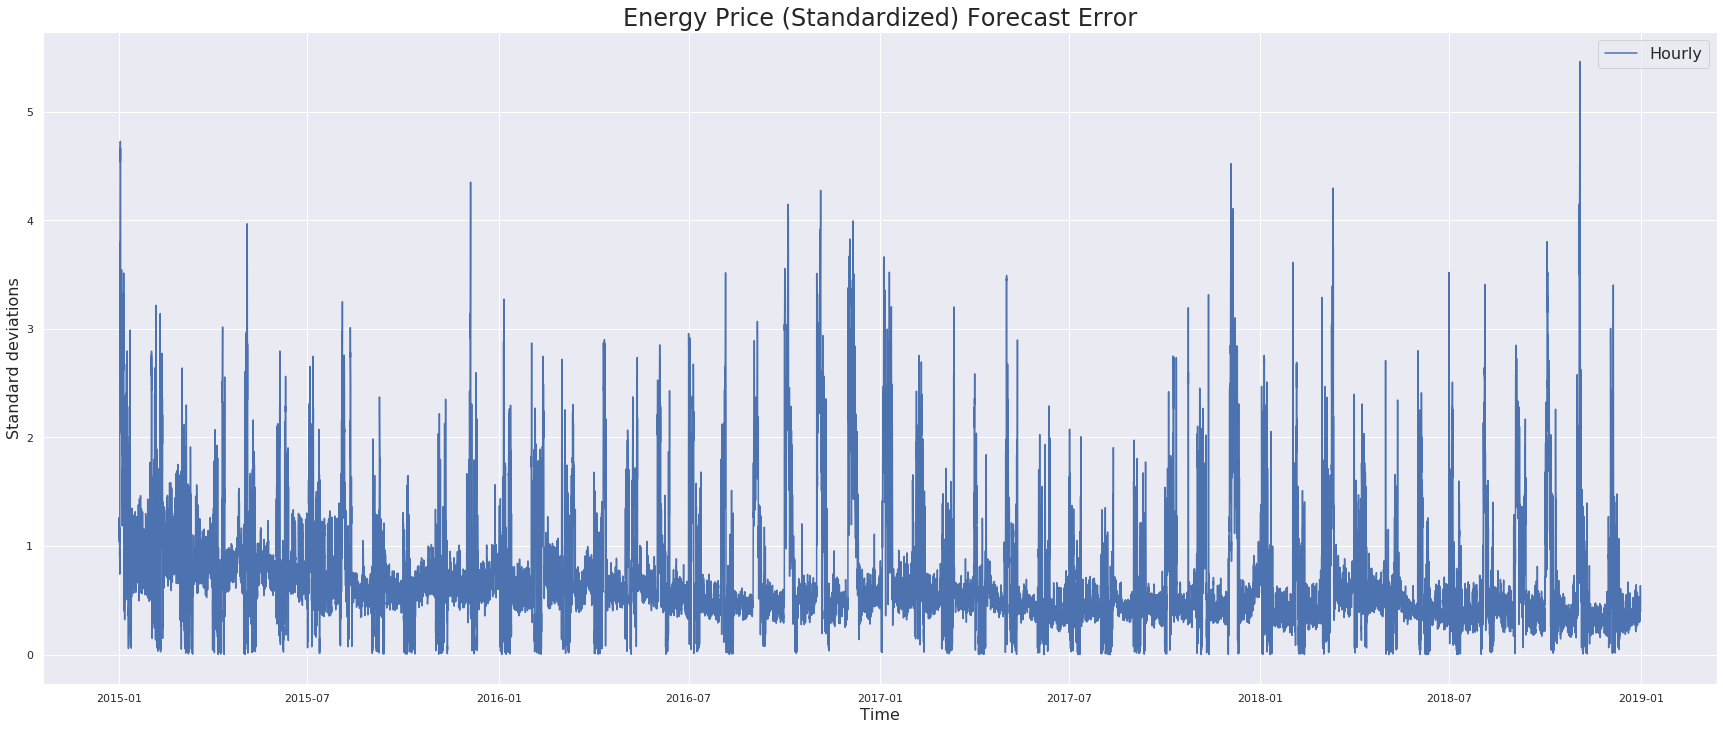

In [45]:
# Plot the standardized absolute hourly error between the actual price and the forecasted price

error_price = abs(df_energy['price actual'] - df_energy['price day ahead'])
standardized_error_price = error_price / (df_energy['price actual'].std())
ax = plot_series(series=standardized_error_price, label='Hourly', 
            ylabel='Standard deviations', title='Energy Price (Standardized) Forecast Error')
plt.show()

We can clearly see some patterns in the errors of the TSO's predictions:
- Regarding the **total load**, the predictions seem very reliable; virtually every prediction is closer than 0.5 standard deviations to the actual one. There are only a few outliers that need to be further investigated.


- Regarding the **energy price**, the errors of the predictions seem to exhibit patterns; in particular, the patterns appear to have periodicity (!) which would probably imply a periodically corrected (or self-correcting) algorithm. However, it is also clear that there is a lot more difficulty in predicting the energy price, since errors larger than 2 standard deviations are pretty common!

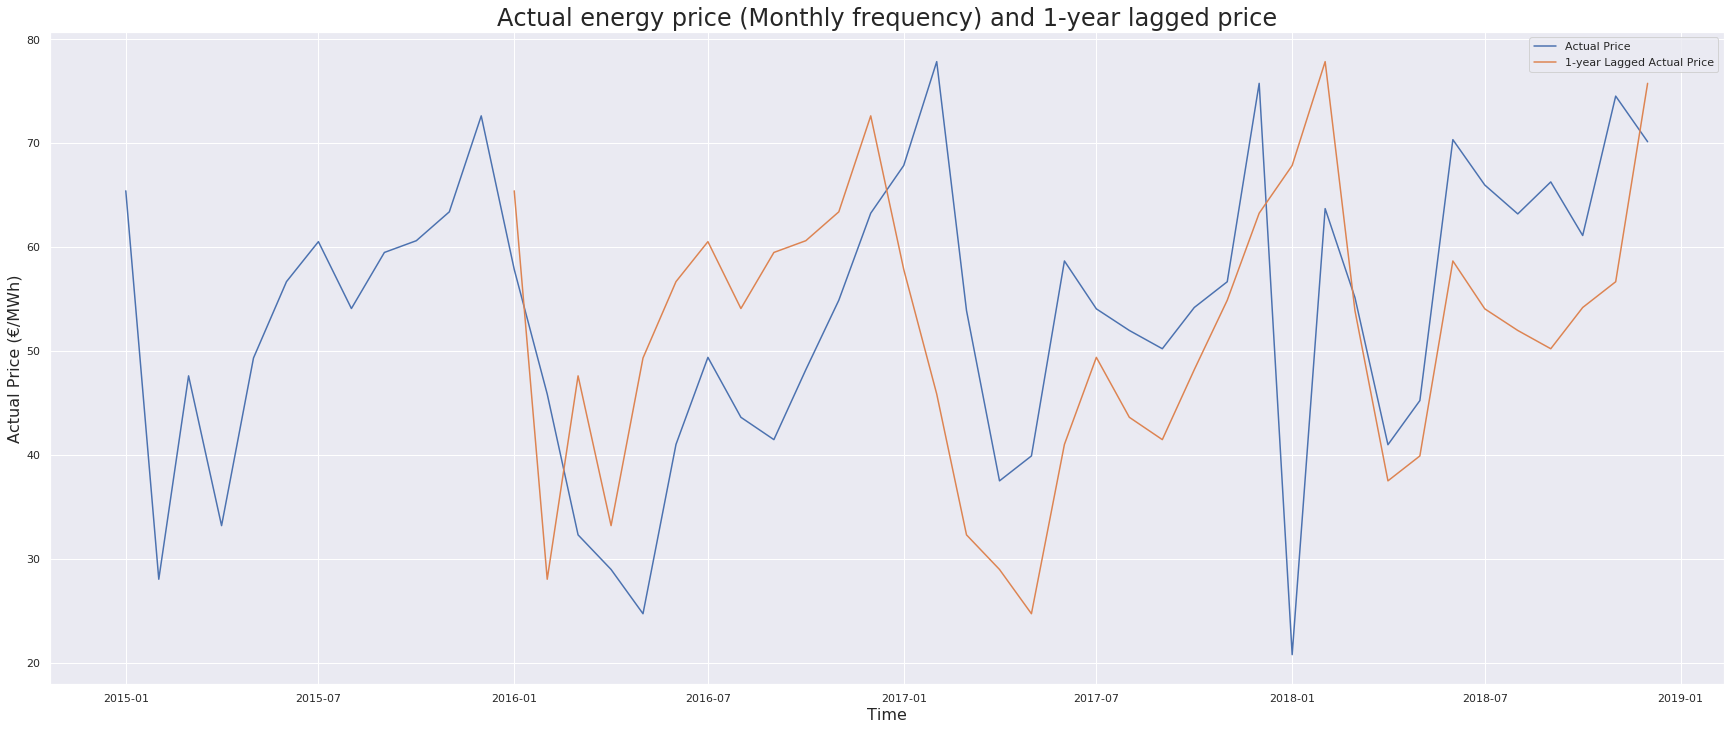

In [46]:
# Plot the energy price (monthly frequence) along with its 1-year lagged series

monthly_price = df_energy['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual energy price (Monthly frequency) and 1-year lagged price')
shifted = df_energy['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the monthly frequency of the actual energy price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed seasonal patterns at the monthly scale, as certain "spikes" in the time-series take place in exactly the same months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

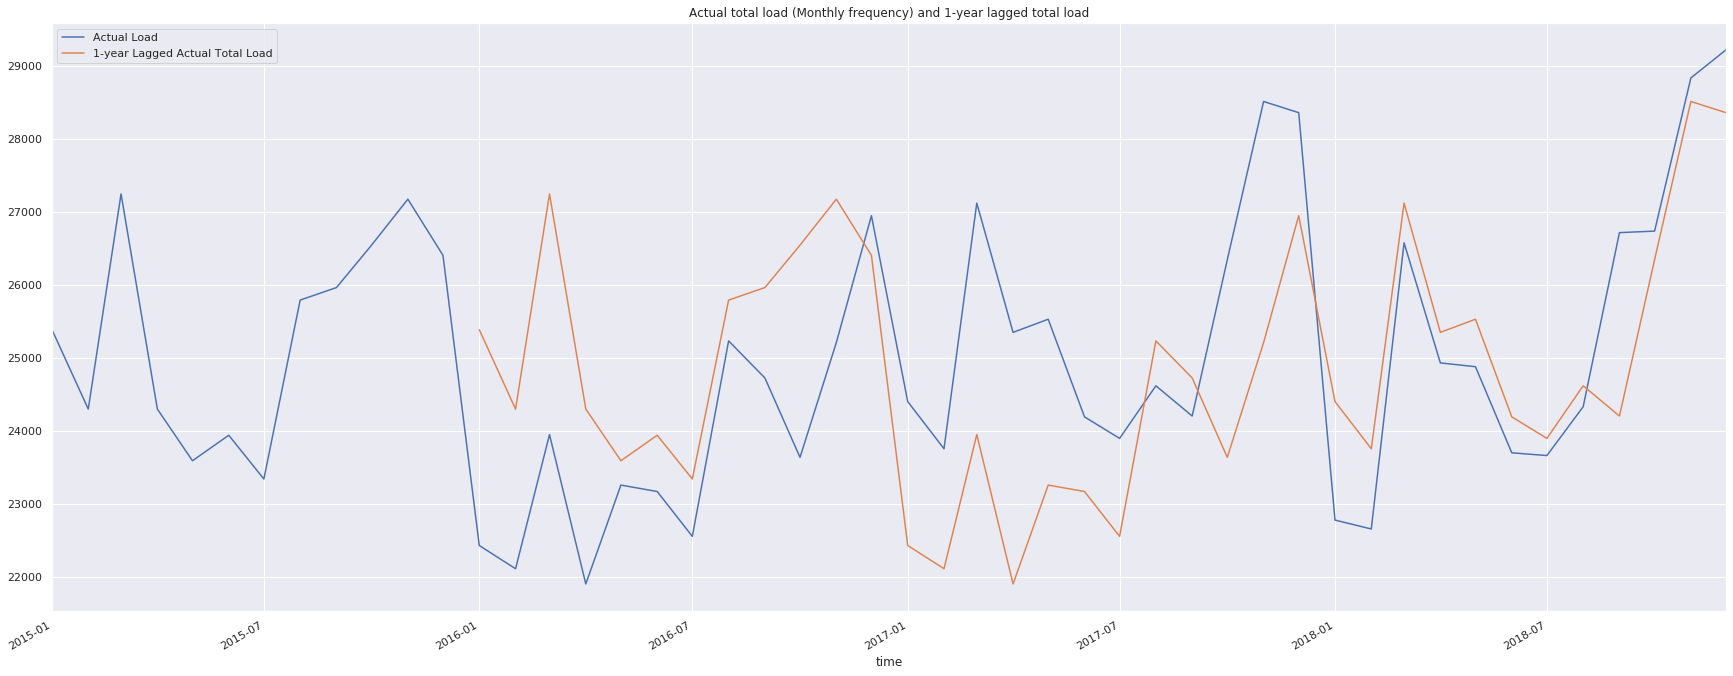

In [47]:
fig, ax = plt.subplots(figsize=(30, 12))
df_energy['total load actual'].asfreq('M').plot(ax=ax)
shifted = df_energy['total load actual'].asfreq('M').shift(12).plot(ax=ax)
ax.set_title('Actual total load (Monthly frequency) and 1-year lagged total load')
ax.legend(['Actual Load', '1-year Lagged Actual Total Load'])
plt.show()

The same story, more or less, is true for the actual total load. Of course, such nation-wide variables are also affected by major political events, such as the 2017-18 Spanish constitutional crisis, also known as the "Catalan crisis".

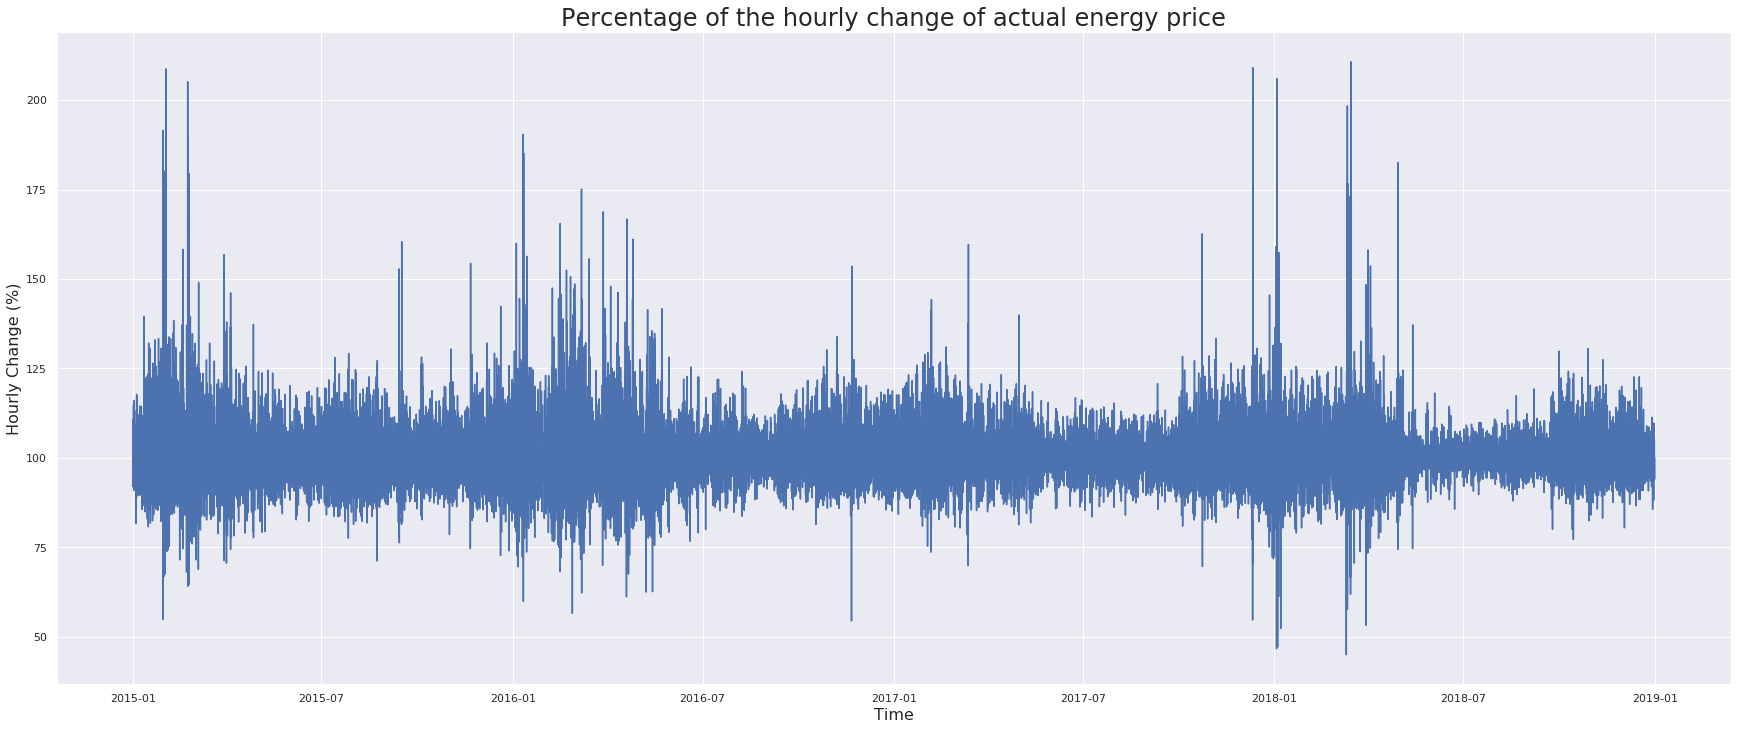

In [48]:
# Plot the percentage of the hourly change in the actual energy price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change of actual energy price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price \* 0.75) and +25% (actual price \* 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

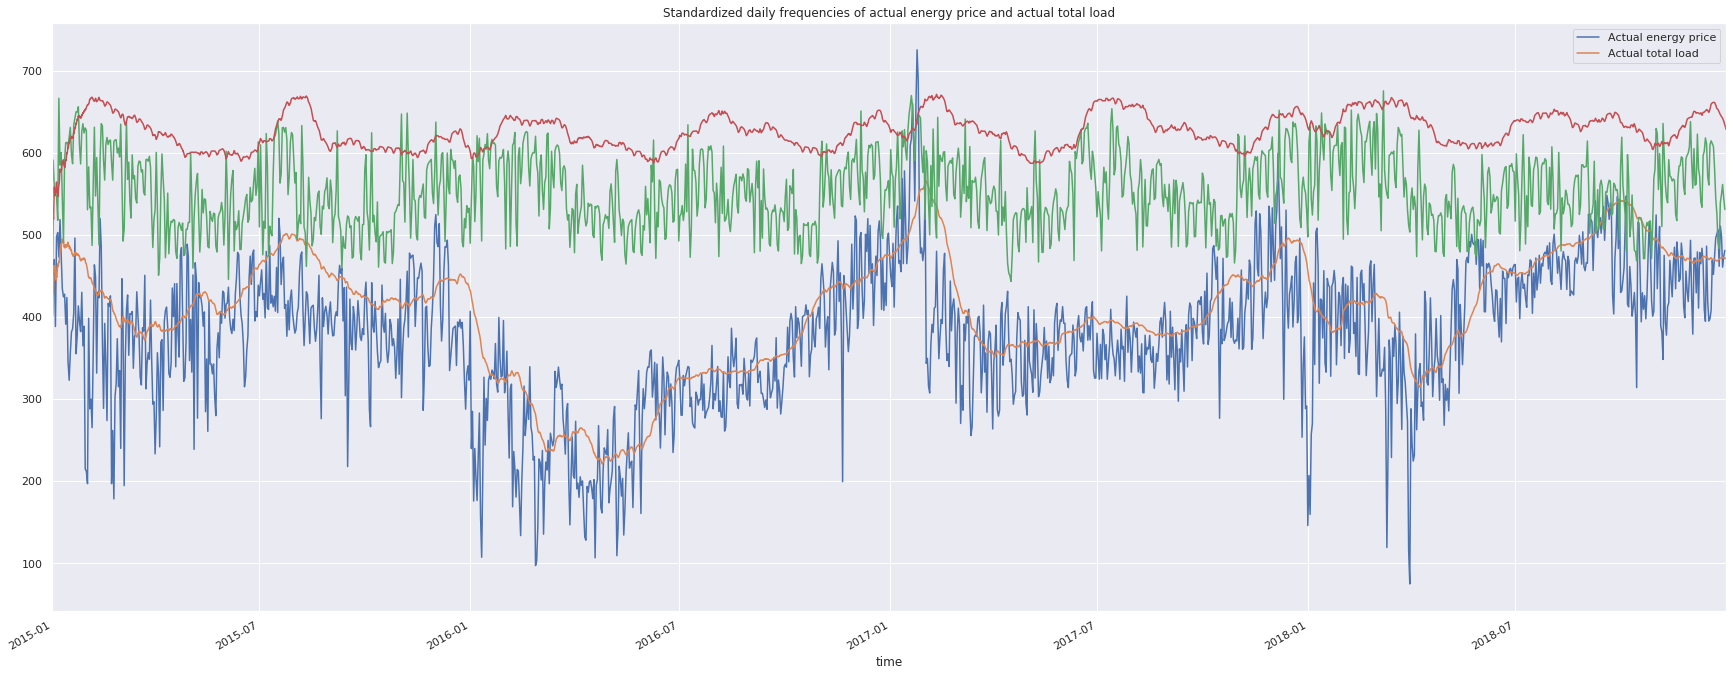

In [49]:
# Plot the standardized daily frequencies of actual energy price and actual total load

fig, ax = plt.subplots(figsize=(30, 12))
standardized_actual_energy = df_energy['price actual'].div(df_energy['price actual'].std()).mul(100)
standardized_actual_total_load = df_energy['total load actual'].div(df_energy['total load actual'].std()).mul(100)
standardized_actual_energy.asfreq('D').plot(ax=ax)
rolling_std_actual_energy = standardized_actual_energy.rolling('30D').mean()
rolling_std_actual_energy.plot(ax=ax)
standardized_actual_total_load.asfreq('D').plot(ax=ax)
rolling_std_actual_total_load = standardized_actual_total_load.rolling('30D').mean()
rolling_std_actual_total_load.plot(ax=ax)
ax.set_title('Standardized daily frequencies of actual energy price and actual total load')
ax.legend(['Actual energy price', 'Actual total load'])
plt.show()

The figure above has no natural sense and is only used so as to get a rough idea of how our two variables (actual energy price and actual total load) change over time. Of course, it is impossible to contrast two variables which have completely different units; however, we can see that they exhibit completely different behaviors both in the daily and the monthly scale. From day to day, the total load does not have the dramatic changes or trends that the energy price has. The same can also be seen with the 30-days (or 1-month) rolling means.

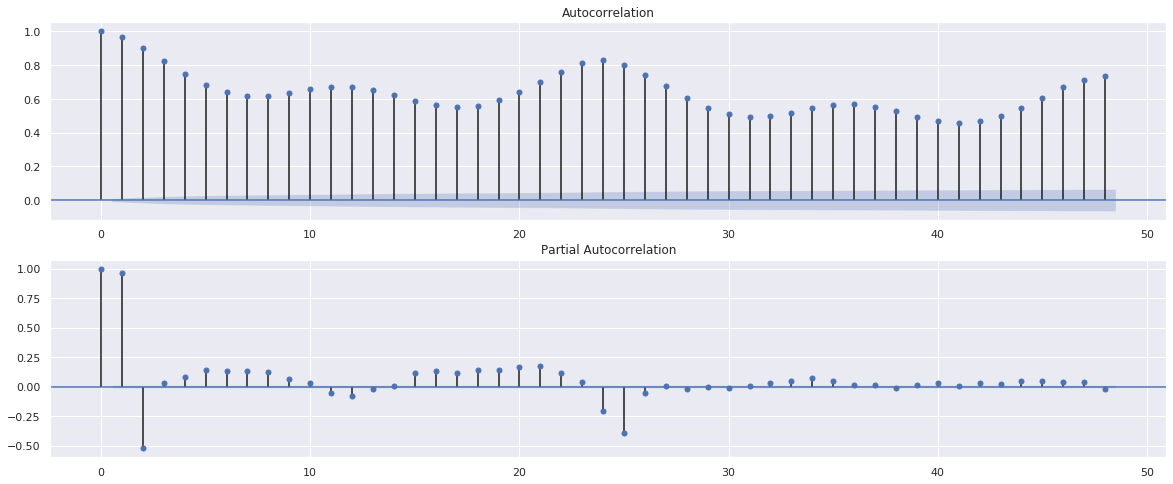

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8))
plot_acf(df_energy['price actual'], ax=ax1, lags=48)
plot_pacf(df_energy['price actual'], ax=ax2, lags=48)
plt.show()

In the figures above we can see the hourly autocorrelation and partial autocorrelation for the actual energy price, for 48 time lags (2 days). 

The autocorrelation function plot shows how the series is correlated with itself at different time lags. It helps with the choice of the MA (Moving average) term. What we can see from the above is that there is 24-hour seasonality, since the peaks coincide with 0, 24 and 48 time lags. CAN WE ALSO SEE A POSITIVE TREND??!

The partial autocorrelation function essentially shows a standard linear regression of the series with itself, i.e. the contribution of that particular lag while holding the others constant. It helps with the choice of the AR (Auto regression) term. The most significant time lags are 0, 1, 2, 24 and 25.

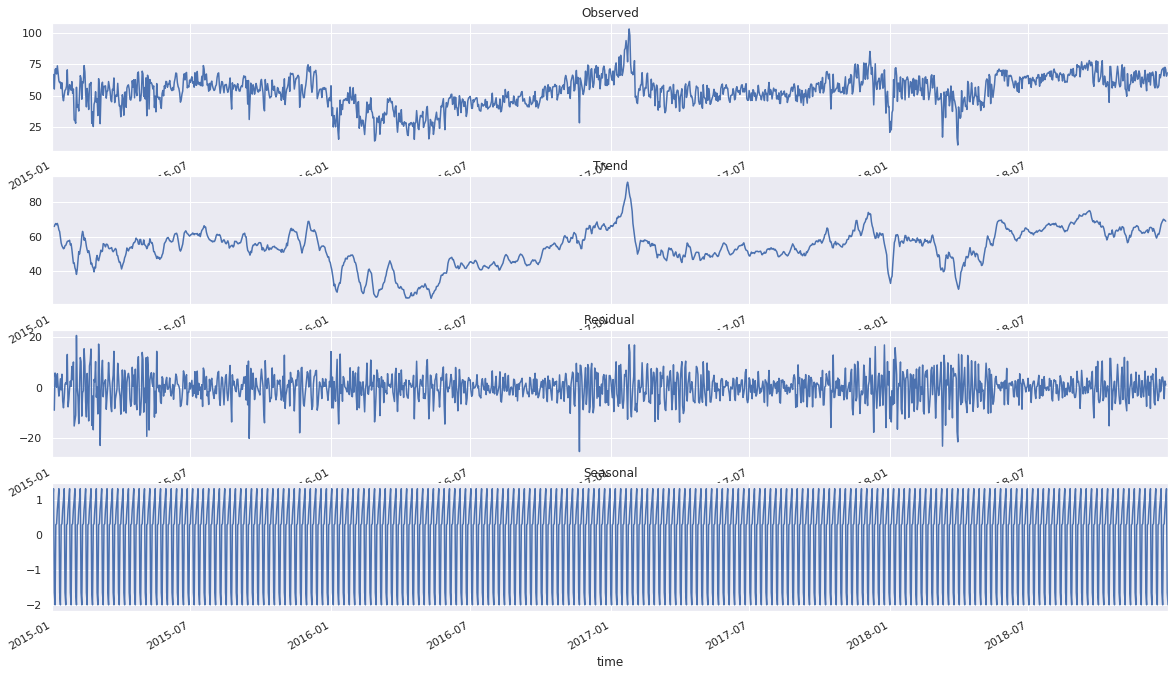

In [51]:
# Decompose the actual energy price time-series with daily frequency

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res = sm.tsa.seasonal_decompose(df_energy['price actual'].asfreq('D'), model='additive')
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.show()

## 3. Cleaning and Merging

## 3. Merging and splitting

In [52]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [53]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp_Barcelona', 'temp_min_Barcelona',
       'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona',
       'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona',
       'rain_3h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'weather_description_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao'

In [54]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'.format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy except first occurrence based on all columns.'.format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy except first occurrence based on all columns.


In [55]:
# Interpolate NaNs and drop duplicates

df_final.interpolate(limit_direction='forward', inplace=True, axis=0)
df_final = df_final.drop_duplicates()

In [56]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'.format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy except first occurrence based on all columns.'.format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy except first occurrence based on all columns.


In [57]:
df_final.shape

(35064, 80)

In [58]:
# Compute the accuracy of TSO's forecasts

def rmse(actual, forecast, string):
    mse = mean_squared_error(actual, forecast)
    rmse = sqrt(mse)
    st_dev = actual.std()
    ratio = rmse / st_dev
    print('\nRMSE of {}: {}'.format(string, round(rmse, 3)))
    print(' For comparison, the standard deviation of {} is: {}'.format(string, round(st_dev), 3))
    print('  The RMSE / standard deviation ratio of {} is: {}'.format(string, round(ratio, 3)))

In [59]:
rmse(df_final['total load actual'], df_final['total load forecast'], 'total load')
rmse(df_final['price actual'], df_final['price day ahead'], 'price')


RMSE of total load: 454.651
 For comparison, the standard deviation of total load is: 4576.0
  The RMSE / standard deviation ratio of total load is: 0.099

RMSE of price: 13.25
 For comparison, the standard deviation of price is: 14.0
  The RMSE / standard deviation ratio of price is: 0.933


As we can see once more, the accuracy of the forecasted total load is better than the accuracy of the forecasted energy price. Indeed, as the RMSE / standard deviation ratio shows, the difference is approximately an **order of magnitude**. Nevertheless, we now have a **target RMSE for the energy price** that we will aim to surpass with our predictive model: `Target RMSE ~ 13.25`

If we are able to surpass that target, it means that we have managed to beat an industry-standard model, which probably uses a lot more data than we have available in the current analysis.

In [60]:
# Split the final dataframe into two: the forecast and the actual

## 4. LSTM modelling and training

## 5. Prediction and evaluation

## 6. Conclusion and further discussion

## 7. References

- <a id='ref1'>[1]</a> https://en.wikipedia.org/wiki/Orders_of_magnitude_(pressure)
- <a id='ref2'>[2]</a> https://en.wikipedia.org/wiki/Orders_of_magnitude_(speed)
- <a id='ref3'>[3]</a> https://en.wikipedia.org/wiki/List_of_European_tornadoes_and_tornado_outbreaks

**Below, you can find more information about the webpages which helped me during the project:**
- https://blog.quantinsti.com/time-series-analysis-date-time-python/
- https://morphocode.com/pandas-cheat-sheet/
- https://towardsdatascience.com/10-python-pandas-tricks-that-make-your-work-more-efficient-2e8e483808ba
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://machinelearningmastery.com/time-series-data-visualization-with-python/
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://www.vinta.com.br/blog/2018/understanding-time-series-forecasting-python/
- https://stackoverflow.com/questions/14247586/python-pandas-how-to-select-rows-with-one-or-more-nulls-from-a-dataframe-without

**Moreover, I used the following Kaggle notebooks as guidelines or as a source of ideas:**
- https://www.kaggle.com/nicholasjhana/multivariate-time-series-forecasting-with-keras
- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
- https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial
- https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders
- https://www.kaggle.com/kcbighuge/predicting-sales-with-a-nested-lstm
- https://www.kaggle.com/nsawal/walmart-baseline-sales-forecasting-lstm
- https://www.kaggle.com/johanvandenheuvel/lstm-model-of-stockdata
- https://www.kaggle.com/janiobachmann/s-p-500-time-series-forecasting-with-prophet

**The academic papers which have been referenced are:**
-


**Key pre-processing and analysis steps left:**

- Parse dt_iso and time correctly and flatten into more features
- Find a way to combine df_energy and df_weather in a supertable
- Change dtypes of df_weather to float64
- Search for and fix missing values and duplicates
- Visualize the distributions of all features
- Zoom into temperature, total load and energy price plots, so as to see intraday behavior
- Correlate total load and energy price with each city's temperature; determine which features play the bigger role
- Visualize energy generation by type as generation size divided by total load to create a nice pie chart!
- Evaluate the accuracy of the forecasts for total load and price made by the TSO "Red Electrica de Espana"
- Determine seasonality, trend and noise (and stationarity?) and gather insights from autocorrelation (for the MA part) and partial autocorrelation plots (for the AR part)
- Segment into multiple train-tests by dividing dataset into time windows (Roll-forward partitioning: Short training period -> Predict validation period -> Move into the future slowly)
- Convert the problem into a supervised learning task of sequences (do not forget -we take as input a sequence and we predict an output sequence; the question is how exactly)
- Decompose the time-series using the multiplicative model as well
- Plot the Supply Curves, which basically are the total load vs. the energy price.

**Research questions and steps:**

- Find which city affects mostly the total load and the price (Madrid?)
- Find which is the most important weather feature (Temperature?)
- Which variable can we predict more accurately (Total Load)
- Decide which variable to predict (Total load or Price?), or search for any other methods of combined predictions
- Set a baseline (naive forecast) and a target (TSO's accuracy); try to steadily increase the baseline model
- Predict the energy price as a univariate forecasting problem using ARIMA or a similar stochastic model (Do we need to difference/normalize the dataset in order to remove the trend and the seasonality? Do we need to first to divide the dataset into time windows?)
- Can we increase the size of the training data by first learning from the TSO model? (Papageorgiou said YES! He also said something about "bootstrapping" and "noisy input")
- Can we combine predictions and correct them so as to be closer together? For example, as correcting them through a joint anomaly detection of two Gaussian distributions for total load and price. Will it yield better results?
- Can we train the Neural Network for two different variables and get better results? (Probably no)
- Decide which kind of Neural Network shall we use (CNN-LSTM, ConvLSTM, Encoder-Decoder LSTM? Papageorgiou said to try many different architectures)
- Can we beat the accuracy of the TSO model? (RMSE/stdev < 0.933? GOOD LUCK!!!)
- Can I also use PCA or SVD? And if yes, how will they improve performance or speed?
- What strategy to use for multi-step forecasting? Direct-Recursive Hybrid strategy (a model for each time step) or Multiple Output strategy (a model which can predict the entire sequence in one shot) 

**Remarks:**

- Predict hourly energy price and total load? One of them? For the day ahead (next 24 hours)? Predict recursively (next 1 hour each time)? Probably use an architecture which takes the actual value as the next input in the sequence.
- What metric to use? MAE? MAPE? RMSE? Probably using MAE (so as not to penalize large errors; but we need to explain why prefer it over RMSE; contrast with similar papers)